# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *Giuseppe Di Poce*

**Matricola**: *2072371*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
import urllib.request
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
import tensorflow_probability as tfp


In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

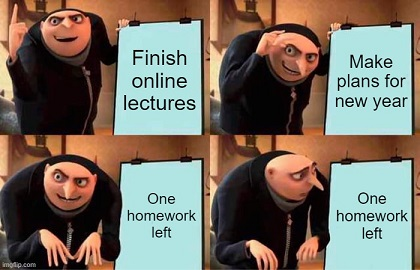

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a SHORT description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

### Introduction:
The aim of this project is to provide a practical example of Transfer Learning: \\
 - In the specific of *model merging* we will focus on Multi-task learning (*MTL*), technique that enables the transfer of knowledge among multiple tasks by *efficiently* sharing model parameters , exploring methodologies for
 effectively merging multiple independently fine-tuned models, with the goal of improve performances across a variety of tasks.\
 We use as model backbone for feature extraction ***ModelNetV2***, a light weight model suitable for Image Classification developed by Google. It is tipical used in mobile devices and strongly reduce the complexity cost and model size of the network wrt other models like VIT for example. \
 In MNV2 the first block perform a depthwise convolution and the second use a fully connected (1x1 convolution) which is responsible for building new features through computing linear combinations of the input channels.

### Tasks & Merging:
Initially the model it's been fine-tuned onto two distinct tasks to perform classification of *human vs horses* and subsequently *cat vs dogs*. Those datasets are not very challenging but we will test the model merging behaviour onto new different task (EuroSAT, that contains images of 10 different satellitar images subjects) and take a look to the behaviour onto already seen data after the merging step.
We performed Model Arithmetic technique with learning by addition and Ada Merging.\
Let's import images!

Labels: ['horses', 'humans']


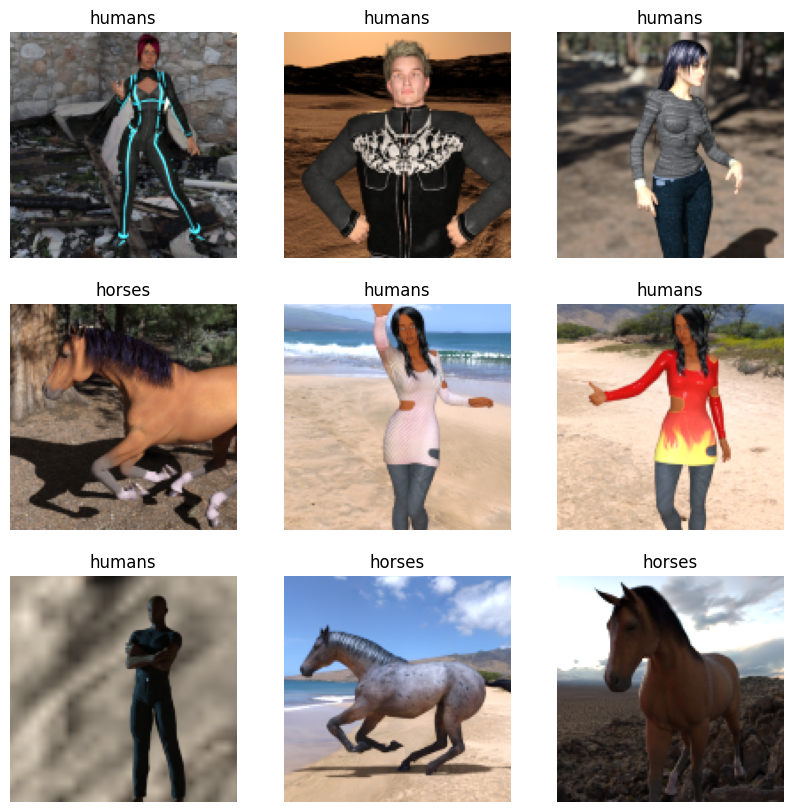

Number of images in the training set: 719


In [ ]:
# Load the HORSES VS HUMANS dataset with test split
(train_horses, validation_horses, test_horses), info = tfds.load('horses_or_humans',
                                                                    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                                                    with_info=True,
                                                                    as_supervised=True)

# Set batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
# input_shape = (128,128,3)

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_h = train_horses.map(format_image).batch(BATCH_SIZE).shuffle(1000)
validation_h = validation_horses.map(format_image).batch(BATCH_SIZE)
test_h = test_horses.map(format_image).batch(BATCH_SIZE)

# Get label names
label_names = info.features['label'].names
print(f"Labels: {label_names}")
# Display some images from the training set with labels
plt.figure(figsize=(10, 10))
for images, labels in train_h.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(label_names[int(labels[i])])
        plt.axis("off")
plt.show()

# Count the number of images in the training set to have an idea of volume of data seen
train_dataset_size = len(list(train_h.unbatch().as_numpy_iterator()))
print(f'Number of images in the training set: {train_dataset_size}')


### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

- Import model backbone, define the architecture adding a Dropout layer and train classification head onto train images;\
Subsequently a fine tune step has been performed, tuning all the model parameters.
### Hyperparameters setting:
$\eta$ (learing rate) = $1e^-5$ \
epochs = $5$

In [ ]:

class CustomModel(tf.keras.Sequential):
    def __init__(self, img_size, label_names):
        super(CustomModel, self).__init__()
        input_shape = img_size + (3,)

        self.lambdas = tf.Variable([0.5, 0.5], dtype=tf.float32, trainable=True)

        # Define the backbone
        self.backbone = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                     include_top=False,
                                                     weights='imagenet')
        self.backbone.trainable = False

        # stack layers and define classificatin head; notice that there is also a dropout layer,
        # differently wrt the original model of MNV2;
        super(CustomModel, self).__init__([
            self.backbone,  # Backbone for feature extraction
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),  # Additional dropout layer
            tf.keras.layers.Dense(len(label_names),
                                  kernel_initializer=tf.keras.initializers.HeNormal(seed=1234))
        ])


model_FT = CustomModel(IMG_SIZE, label_names)
model_FT.build((None, *IMG_SIZE, 3))
model_FT.summary()

Model: "custom_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


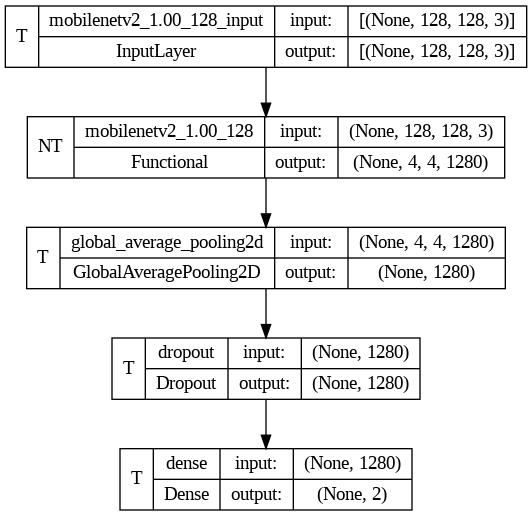

In [ ]:
tf.keras.utils.plot_model(model_FT, show_shapes=True, show_trainable=True)

In [ ]:
def train_head(validation, train, test, backbone, model, lr=1e-5, epochs = 5,  logits = True ):
  backbone.trainable= False
  learning_rate = 1e-5
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits= logits),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  history = model.fit(train , epochs= epochs, validation_data = validation) #here data are taken from scope out of the function for simplicity
  loss, accuracy = model.evaluate(test)
  print(f"\n Accuracy after classification head training on test set: {round(accuracy,4)}")
  return loss, accuracy


def fine_tuning(validation, train, test, backbone, model, lr=1e-5, epochs = 5, logits = True ):
  backbone.trainable = True
  #here we pay attention to batchNormalization layers that must be freezed also in the fine tuning step as explained above;
  for layer in backbone.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = logits),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  #fine tune the model:
  fine_tuning = model.fit(train,
                          epochs = epochs,
                          validation_data=validation)
  loss_, accuracy_ = model.evaluate(test)
  print(f"\n Accuracy after fine tuning on test set: {round(accuracy_,4)}")
  return loss_, accuracy_

In [ ]:
L_head_h, acc_head_h = train_head(validation_h, train_h, test_h, model_FT.backbone, model_FT)

Epoch 1/5
23/23 [==============================] - 8s 117ms/step - loss: 0.9196 - sparse_categorical_accuracy: 0.4854 - val_loss: 0.7898 - val_sparse_categorical_accuracy: 0.5844
Epoch 2/5
23/23 [==============================] - 0s 19ms/step - loss: 0.8506 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.7524 - val_sparse_categorical_accuracy: 0.5844
Epoch 3/5
23/23 [==============================] - 0s 18ms/step - loss: 0.7974 - sparse_categorical_accuracy: 0.5744 - val_loss: 0.7163 - val_sparse_categorical_accuracy: 0.6169
Epoch 4/5
23/23 [==============================] - 0s 18ms/step - loss: 0.7629 - sparse_categorical_accuracy: 0.5855 - val_loss: 0.6833 - val_sparse_categorical_accuracy: 0.6364
Epoch 5/5
5/5 [==============================] - 0s 26ms/step - loss: 0.6354 - sparse_categorical_accuracy: 0.6883

 Accuracy after classification head training on test set: 0.6883


- Important about Batch Normalization Layer:

BatchNormalization layers need particular attention when performing fine-tuning becausevwhen the layers is set as trainable = False the BatchNormalization layer will run in inference mode, and will not update its mean and variance.\
When we unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, we should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model. *Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned*.
[Tensorflow reference](https://www.tensorflow.org/tutorials/images/transfer_learning#important_note_about_batchnormalization_layers)

In [ ]:
#unfreeze the backbone and fine tune the model;
L_ft_h, acc_ft_h = fine_tuning(validation_h, train_h, test_h, model_FT.backbone, model_FT)

Epoch 1/5
23/23 [==============================] - 15s 127ms/step - loss: 0.1976 - sparse_categorical_accuracy: 0.9277 - val_loss: 0.0210 - val_sparse_categorical_accuracy: 0.9935
Epoch 2/5
23/23 [==============================] - 1s 56ms/step - loss: 0.0138 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0073 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/5
23/23 [==============================] - 1s 58ms/step - loss: 0.0044 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0047 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/5
23/23 [==============================] - 1s 58ms/step - loss: 0.0027 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0044 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
5/5 [==============================] - 0s 15ms/step - loss: 0.0027 - sparse_categorical_accuracy: 1.0000

 Accuracy after fine tuning on test set: 1.0


In [ ]:
model_FT.summary() #check unfreezed parameters:

Model: "custom_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2192322 (8.36 MB)
Non-trainable params: 68224 (266.50 KB)
_________________________________________________________________


Now we can compute the task vector $\tau_k$ :\
 it is obtained by subtracting the pre-trained
 weights $\theta_{pre}$ from the model weights $\theta^k_{FT}$ fine-tuned on the data of task $k$.\
 At the end we will perform the final model weights update as:\
  $$\theta_{\tau} = \theta_{pre} + \lambda (\sum^K_{k=1} \tau_k)$$
where $\lambda$ is a merging coefficent that weight the task vectors summation.\
***Please notice that here $\lambda$ is the same for each task vector $\tau_k$, i.e. there is no distinction in the different "importance" of task vectors in the weights space, and this can create lack of adaptability when the $k$ number of task increase.***

In [ ]:
w_FT = model_FT.get_weights()
input_shape = IMG_SIZE + (3,)
model_FT.backbone = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
w_V2 = model_FT.backbone.get_weights()
#compute the task vector
task_v1 = [tf.subtract(w1, w2) for w1, w2 in zip(w_FT, w_V2)] #notice that here we need the whole fine tuning of the model to extract task vector
                                                              # This is one of the "dark part" of task arithmetic paradigma;

Now let's import cat and dogs dataset and repeat previous step onto the new task in order to extract the second task vector $\tau$.

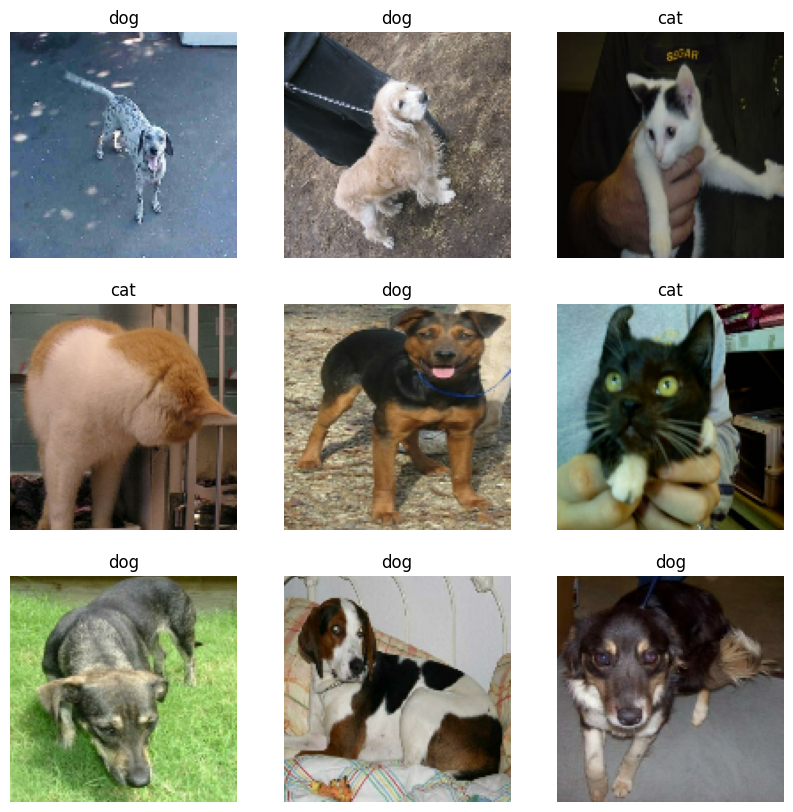

In [ ]:
(train_dataset, validation_dataset, test_dataset), info = tfds.load('cats_vs_dogs',
                                                                    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                                                    with_info=True,
                                                                    as_supervised=True)

train_cat = train_dataset.map(format_image).batch(BATCH_SIZE).shuffle(1000)
validation_cat = validation_dataset.map(format_image).batch(BATCH_SIZE)
test_cat = test_dataset.map(format_image).batch(BATCH_SIZE)

# Get label names
label_names = info.features['label'].names
#print(f"Labels: {label_names}")
# Display some images from the training set with labels
plt.figure(figsize=(10, 10))
for images, labels in train_cat.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(label_names[int(labels[i])])
        plt.axis("off")
plt.show()



In [ ]:
model_FT = CustomModel(IMG_SIZE, label_names)
model_FT.build((None, *IMG_SIZE, 3))
model_FT.summary()

Model: "custom_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
L_head_c, acc_head_c = train_head(validation_cat, train_cat, test_cat, model_FT.backbone, model_FT)

Epoch 1/5
509/509 [==============================] - 18s 21ms/step - loss: 0.5530 - sparse_categorical_accuracy: 0.7350 - val_loss: 0.3786 - val_sparse_categorical_accuracy: 0.8398
Epoch 2/5
509/509 [==============================] - 13s 18ms/step - loss: 0.3727 - sparse_categorical_accuracy: 0.8417 - val_loss: 0.2720 - val_sparse_categorical_accuracy: 0.8986
Epoch 3/5
509/509 [==============================] - 13s 18ms/step - loss: 0.2859 - sparse_categorical_accuracy: 0.8876 - val_loss: 0.2191 - val_sparse_categorical_accuracy: 0.9206
Epoch 4/5
  1/509 [..............................] - ETA: 35:33 - loss: 0.2255 - sparse_categorical_accuracy: 0.9375

In [ ]:
#unfreeze the backbone and fine tune the model;
L_ft_c, acc_ft_c = fine_tuning(validation_cat, train_cat, test_cat, model_FT.backbone, model_FT)

Epoch 1/5
509/509 [==============================] - 43s 60ms/step - loss: 0.0876 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.0616 - val_sparse_categorical_accuracy: 0.9779
Epoch 2/5
509/509 [==============================] - 33s 57ms/step - loss: 0.0451 - sparse_categorical_accuracy: 0.9827 - val_loss: 0.0558 - val_sparse_categorical_accuracy: 0.9819
Epoch 3/5
509/509 [==============================] - 33s 57ms/step - loss: 0.0292 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0617 - val_sparse_categorical_accuracy: 0.9794
Epoch 4/5
509/509 [==============================] - 33s 57ms/step - loss: 0.0181 - sparse_categorical_accuracy: 0.9933 - val_loss: 0.0787 - val_sparse_categorical_accuracy: 0.9782
Epoch 5/5
110/110 [==============================] - 2s 14ms/step - loss: 0.0748 - sparse_categorical_accuracy: 0.9756

 Accuracy after fine tuning on test set: 0.9756


In [ ]:
w_FT = model_FT.backbone.get_weights()
model_FT.backbone = tf.keras.applications.MobileNetV2(input_shape= IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
w_V2 = model_FT.backbone.get_weights()
#compute the task vector
task_v2 = [tf.subtract(w1, w2) for w1, w2 in zip(w_FT, w_V2)]

In [ ]:
task_v2

[<tf.Tensor: shape=(3, 3, 3, 32), dtype=float32, numpy=
 array([[[[ 0.00000000e+00,  0.00000000e+00,  2.81766057e-04,
            0.00000000e+00, -1.02010462e-03,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00, -4.71189618e-04,
            6.20231032e-04,  4.08351421e-04,  1.69757754e-04,
           -2.92092562e-04,  4.31671739e-04,  2.41339207e-04,
           -3.59461410e-05, -1.07325613e-04,  4.35292721e-04,
            0.00000000e+00,  0.00000000e+00, -1.08015537e-03,
           -2.48100609e-04,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00,  6.76265918e-04,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            4.20294702e-04, -1.65045261e-04],
          [ 0.00000000e+00,  0.00000000e+00,  2.82227993e-04,
            0.00000000e+00, -9.35617834e-04,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00, -6.28083944e-04,
            5.59628010e-04,  6.71386719e-04,  1.19386241e-04,
           -2.55525112e-04,  4

### Task Arithmetic:
Once the task vectors have been extracted as explained above we can implement model merging and evaluate its perfomances:\
to do this we start by importing the data for the new task not seen by the model on which we will test the merging model with the shared parameters;

Labels: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


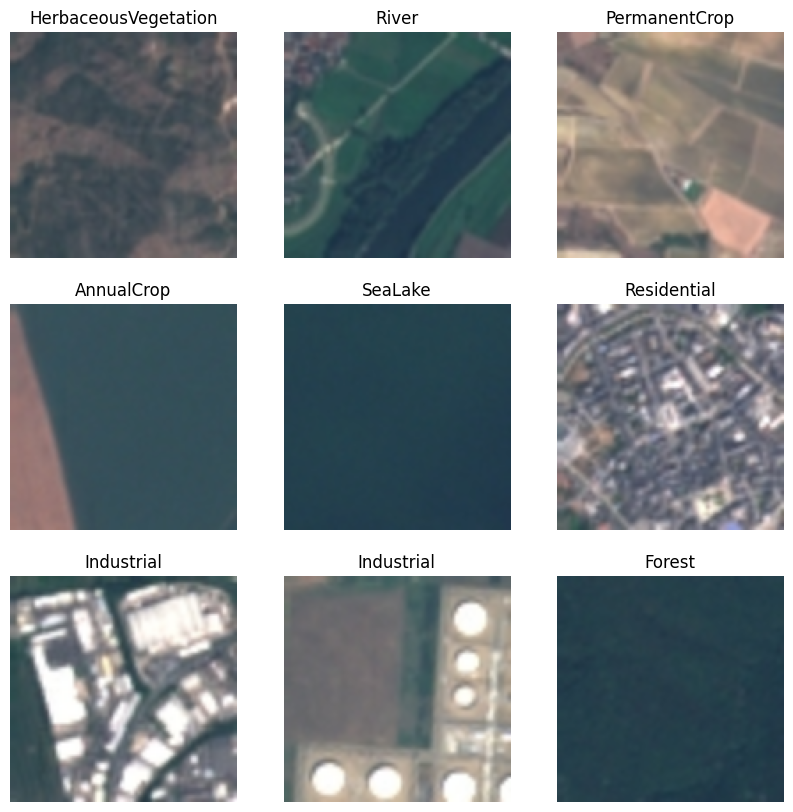

Number of images in the training set: 18900


In [ ]:
(train_dataset, validation_dataset, test_dataset), info = tfds.load('eurosat',
                                                                    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                                                    with_info=True,
                                                                    as_supervised=True)

# Set batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_m = train_dataset.map(format_image).batch(BATCH_SIZE).shuffle(1000)
validation_m = validation_dataset.map(format_image).batch(BATCH_SIZE)
test_m = test_dataset.map(format_image).batch(BATCH_SIZE)

# Get label names
label_names = info.features['label'].names
print(f"Labels: {label_names}")
# Display some images from the training set with labels
plt.figure(figsize=(10, 10))
for images, labels in train_m.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(label_names[int(labels[i])])
        plt.axis("off")
plt.show()

# Count the number of images in the training set
train_dataset_size = len(list(train_m.unbatch().as_numpy_iterator()))
print(f'Number of images in the training set: {train_dataset_size}')


From now on we will:

$1.$ Initialize the model and train its classification head onto EuroSAT;\
$2.$ Set $\lambda$ penalization for $\tau$ by hold out cross validation;\
where $\tau = \sum_{k=1}^K \tau_k$ \
$3.$ Compute task vector wrt new EuroSAT task in order to campare it with other $\tau_k$ by cosine similarity (more explanation inside the code cell).


In [ ]:
task_model = CustomModel(IMG_SIZE, label_names)
task_model.build((None, *IMG_SIZE, 3))
task_model.summary()

Model: "custom_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2270794 (8.66 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
L_head_m, acc_head_m = train_head(validation_m, train_m, test_m, task_model.backbone, task_model)
#This is the accuracy obtained with a model that have pre trained backbone and head trained onto this specific task.
#Now we need to investigate how much (and if) we gain in term of performnces updating the backbone pre trained model
#with task arithmetic;

Epoch 1/5
591/591 [==============================] - 16s 21ms/step - loss: 2.3931 - sparse_categorical_accuracy: 0.1983 - val_loss: 1.9011 - val_sparse_categorical_accuracy: 0.3568
Epoch 2/5
591/591 [==============================] - 11s 17ms/step - loss: 1.8259 - sparse_categorical_accuracy: 0.3750 - val_loss: 1.4981 - val_sparse_categorical_accuracy: 0.5417
Epoch 3/5
591/591 [==============================] - 11s 17ms/step - loss: 1.4915 - sparse_categorical_accuracy: 0.4990 - val_loss: 1.2462 - val_sparse_categorical_accuracy: 0.6284
Epoch 4/5
591/591 [==============================] - 11s 17ms/step - loss: 1.2771 - sparse_categorical_accuracy: 0.5759 - val_loss: 1.0783 - val_sparse_categorical_accuracy: 0.6763
Epoch 5/5
127/127 [==============================] - 2s 15ms/step - loss: 0.9395 - sparse_categorical_accuracy: 0.7269

 Accuracy after classification head training on test set: 0.7269


In [ ]:
print(L_head_m)

0.9395474195480347


In [ ]:
# Define the function to create and compile the model
def create_task_model(task_v1, task_v2, model, lambd):
    T_ = [tf.add(v1, v2) for v1, v2 in zip(task_v1, task_v2)]
    Theta_new = [tf.add(pre, (lambd * t)) for pre,t in zip(model.backbone.get_weights(), T_)]
    model.backbone.set_weights(Theta_new)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model.trainable=True
    model.backbone.trainable=False
    return model

# Grid search over lambda values
lambda_values = np.linspace(0.0, 0.15, 10) #for Colab issues i've restrict the grid search onto intervals onto which performance are better;
                                           # put the linspace from zero to one would blow up my notebook!!!
best_lambda = None
best_val_accuracy = 0


for lambd in lambda_values:
    print(f"Testing lambda value: {lambd}")
    model = create_task_model(task_v1, task_v2, task_model, lambd)
    history = model.fit(
        train_m,
        validation_data=validation_m,
        epochs=5,
        verbose=0
    )
    val_accuracy = history.history['val_sparse_categorical_accuracy'][-1]
    print(f"Validation accuracy for lambda {lambd}: {round(val_accuracy,4)}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_lambda = lambd

print(f"Best lambda value: {best_lambda}")
print(f"Best validation accuracy: {best_val_accuracy}")


# Evaluate the model with the best lambda value on the test dataset
best_model = create_task_model(task_v1, task_v2, task_model, best_lambda)
best_model.fit(
    train_m,
    validation_data=validation_m,
    epochs=5  # Ensure the model is trained fully
)
test_loss_arithm, test_accuracy_arithm = best_model.evaluate(test_m)

print(f'Test loss: {test_loss_arithm}')
print(f'Test accuracy: {test_accuracy_arithm}')

Testing lambda value: 0.0
Validation accuracy for lambda 0.0: 0.7965
Testing lambda value: 0.016666666666666666
Validation accuracy for lambda 0.016666666666666666: 0.8217
Testing lambda value: 0.03333333333333333
Validation accuracy for lambda 0.03333333333333333: 0.8405
Testing lambda value: 0.05
Validation accuracy for lambda 0.05: 0.8548
Testing lambda value: 0.06666666666666667
Validation accuracy for lambda 0.06666666666666667: 0.8583
Testing lambda value: 0.08333333333333333
Validation accuracy for lambda 0.08333333333333333: 0.8563
Testing lambda value: 0.1
Validation accuracy for lambda 0.1: 0.8565
Testing lambda value: 0.11666666666666667
Validation accuracy for lambda 0.11666666666666667: 0.8514
Testing lambda value: 0.13333333333333333
Validation accuracy for lambda 0.13333333333333333: 0.8447
Testing lambda value: 0.15
Validation accuracy for lambda 0.15: 0.8356
Best lambda value: 0.06666666666666667
Best validation accuracy: 0.858271598815918
Epoch 1/5
591/591 [==========

In [ ]:
#Let's also fine tune this model in order to extract the task vector wrt EuroSAT data and compare
#the latter task vector with the others by cosine similarity. This step will provide us an idea of
#in which direction in the weights space the task vector are;
fine_model = CustomModel(IMG_SIZE, label_names)
fine_model.build((None, *IMG_SIZE, 3)) #re-initilize model trained onto imageNet and fine tune it

L_ft_m , acc_ft_m = fine_tuning(validation_m, train_m, test_m, fine_model.backbone, fine_model)

Epoch 1/5
591/591 [==============================] - 45s 59ms/step - loss: 0.5732 - sparse_categorical_accuracy: 0.8070 - val_loss: 0.2998 - val_sparse_categorical_accuracy: 0.8983
Epoch 2/5
591/591 [==============================] - 34s 56ms/step - loss: 0.2592 - sparse_categorical_accuracy: 0.9114 - val_loss: 0.2229 - val_sparse_categorical_accuracy: 0.9272
Epoch 3/5
591/591 [==============================] - 34s 56ms/step - loss: 0.1900 - sparse_categorical_accuracy: 0.9360 - val_loss: 0.1881 - val_sparse_categorical_accuracy: 0.9358
Epoch 4/5
591/591 [==============================] - 34s 56ms/step - loss: 0.1500 - sparse_categorical_accuracy: 0.9492 - val_loss: 0.1675 - val_sparse_categorical_accuracy: 0.9447
Epoch 5/5
127/127 [==============================] - 2s 14ms/step - loss: 0.1804 - sparse_categorical_accuracy: 0.9398

 Accuracy after fine tuning on test set: 0.9398


In [ ]:
#extract task_vector of euroSAT
w_tuned = fine_model.backbone.get_weights()
fine_model.backbone = tf.keras.applications.MobileNetV2(input_shape= IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_backb = task_model.backbone.get_weights()
#compute the task vector
task_v3 = [tf.subtract(w1, w2) for w1, w2 in zip(w_tuned, base_backb)]

In [ ]:
task_v3

[<tf.Tensor: shape=(3, 3, 3, 32), dtype=float32, numpy=
 array([[[[ 0.00000000e+00,  0.00000000e+00,  2.03974545e-03,
            0.00000000e+00, -1.11741200e-03,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00, -1.05447322e-03,
           -8.23616982e-04,  7.14749098e-04, -2.02390924e-03,
            2.74658203e-04, -1.54565275e-03, -2.22927332e-03,
           -3.05841968e-04, -2.02292576e-03,  2.51352787e-04,
            0.00000000e+00,  0.00000000e+00,  9.96112823e-04,
            3.94521840e-03,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00,  1.36376359e-04,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            2.35984474e-03,  2.63744593e-03],
          [ 0.00000000e+00,  0.00000000e+00,  3.41004133e-03,
            0.00000000e+00, -1.33522041e-03,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00, -2.00277567e-03,
           -1.16705894e-03,  2.01165676e-04, -1.55939162e-03,
            2.40504742e-04, -6

In [ ]:
L_ta_c, acc_ta_c = train_head(validation_cat, train_cat, test_cat, best_model.backbone, best_model)

Epoch 1/5
509/509 [==============================] - 16s 19ms/step - loss: 4.2096 - sparse_categorical_accuracy: 0.1826 - val_loss: 2.5208 - val_sparse_categorical_accuracy: 0.4195
Epoch 2/5
509/509 [==============================] - 13s 18ms/step - loss: 1.7810 - sparse_categorical_accuracy: 0.5341 - val_loss: 0.9899 - val_sparse_categorical_accuracy: 0.6905
Epoch 3/5
509/509 [==============================] - 13s 17ms/step - loss: 0.7874 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.4790 - val_sparse_categorical_accuracy: 0.8447
Epoch 4/5
509/509 [==============================] - 13s 17ms/step - loss: 0.4427 - sparse_categorical_accuracy: 0.8505 - val_loss: 0.3048 - val_sparse_categorical_accuracy: 0.9020
Epoch 5/5
110/110 [==============================] - 2s 14ms/step - loss: 0.2297 - sparse_categorical_accuracy: 0.9324

 Accuracy after classification head training on test set: 0.9324


In [ ]:
L_ta_h, acc_ta_h = train_head(validation_h, train_h, test_h, best_model.backbone, best_model)

Epoch 1/5
23/23 [==============================] - 4s 58ms/step - loss: 1.2692 - sparse_categorical_accuracy: 0.5688 - val_loss: 1.0539 - val_sparse_categorical_accuracy: 0.5779
Epoch 2/5
23/23 [==============================] - 0s 18ms/step - loss: 1.2231 - sparse_categorical_accuracy: 0.5661 - val_loss: 0.9940 - val_sparse_categorical_accuracy: 0.5779
Epoch 3/5
23/23 [==============================] - 0s 18ms/step - loss: 1.1243 - sparse_categorical_accuracy: 0.5869 - val_loss: 0.9365 - val_sparse_categorical_accuracy: 0.5974
Epoch 4/5
23/23 [==============================] - 0s 18ms/step - loss: 1.0803 - sparse_categorical_accuracy: 0.6050 - val_loss: 0.8833 - val_sparse_categorical_accuracy: 0.6169
Epoch 5/5
5/5 [==============================] - 0s 15ms/step - loss: 1.1661 - sparse_categorical_accuracy: 0.5649

 Accuracy after classification head training on test set: 0.5649


- First step Conclusions: \


In [ ]:
table = {
    'pretrained': [acc_head_h, acc_head_c, acc_head_m],
    'Individual': [acc_ft_h, acc_ft_c, acc_ft_m],
    'Task Arithmetic': [acc_ta_h, acc_ta_c, test_accuracy_arithm]
}
import pandas as pd
table_results = pd.DataFrame(table, index=['Horses vs Humans', 'Cats vs Dogs', 'EuroSAT'])
print("The following table show accuracy of MBV2 onto different tasks: \n")
print(table_results)

The following table show accuracy of MBV2 onto different tasks: 

                  pretrained  Individual  Task Arithmetic
Horses vs Humans    0.688312    1.000000         0.564935
Cats vs Dogs        0.931499    0.975638         0.932359
EuroSAT             0.726914    0.939753         0.842469


Notice that we improve our perfoamnces using Task Arithmetic model onto EuroSAT images wrt the pretrained one ("pretrained" means pretrained weigths in the backbone and head trained onto the specific task).

In [ ]:
def concatenate_weights(weights):
    # Flatten each tensor in the list and concatenate them into a single tensor
    flattened_weights = [tf.reshape(w, [-1]) for w in weights]
    concatenated_weights = tf.concat(flattened_weights, axis=0)
    return concatenated_weights


def cosine_similarity(tensor1, tensor2):
    dot_product = tf.tensordot(tensor1, tensor2, axes=1)
    norm_tensor1 = tf.norm(tensor1)
    norm_tensor2 = tf.norm(tensor2)
    return (dot_product / (norm_tensor1 * norm_tensor2)).numpy()

w1 = concatenate_weights(task_v1)
w2 = concatenate_weights(task_v2)
w3=  concatenate_weights(task_v3)

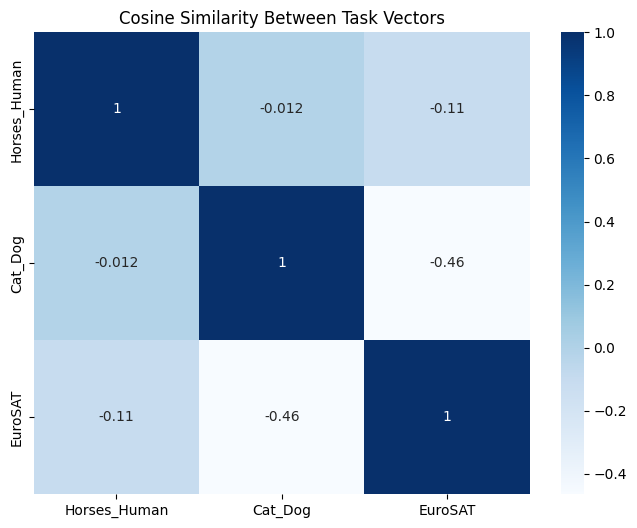

In [ ]:

# Calculate cosine similarities
similarities = {
    'Horses_Human': [cosine_similarity(w1, w1), cosine_similarity(w1, w2), cosine_similarity(w1, w3)],
    'Cat_Dog': [cosine_similarity(w2, w1), cosine_similarity(w2, w2), cosine_similarity(w2, w3)],
    'EuroSAT': [cosine_similarity(w3, w1), cosine_similarity(w3, w2), cosine_similarity(w3, w3)]
}

similarity_df = pd.DataFrame(similarities, index=['Horses_Human', 'Cat_Dog', 'EuroSAT'])
similarity_ = similarity_df.to_numpy()

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap='Blues', cbar=True,xticklabels=similarity_df.columns, yticklabels=similarity_df.columns)
plt.title('Cosine Similarity Between Task Vectors')
plt.show()

## Coclusions:
It is interesting to note that there are all-negative similarities between them and especially that there is a deviation (big one) of -0.46 among EuroSAT and Cat vs Dog data.\
Although the arithhemtic task model is built via addition just using the first two task vectors, the third gives us an idea of the direction in the space of weights toward which we need to move to improve performance on that particular task.
A large and negative deviation means that the two task vectors $\tau_{euroSAT}$ and $\tau_{cat}$ are relatively opposite in their direction.\
*This is so focus our attention on the fact that those type of models are quite easy to implement but have a lack of robustness with respect to the reason why they works and can be very sensitive to potential conflicts and intricate correlations among the multiple tasks*:\
here due to better model performances I expected the EuroSAT task_vector between the two task vectors computed above. On the contrary these have opposite direction;\
Furthermore when the number of tasks is large, grid
 searching the merging coefficients for each task vector is really expensive.\
For the sake of the last backward mentioned, Ada Merging (Adaptive model merging) can help us...

## ADAPTIVE MODEL MERGING FOR MULTI-TASK LEARNING
reference:[Ada Merging](https://arxiv.org/abs/2310.02575)

This model makes the merging coefficient $\lambda$ of each task vector learnable by the following unconstrained optimization problem: (in this notation $T_k$ are task vectors)

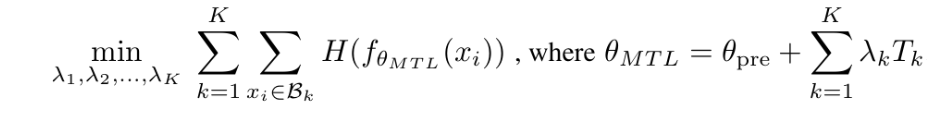

 It leverages entropy minimization $H()$  from the
 multi-task setup to iteratively refine the merging
 coefficients $\lambda_k$ of the multiple task vactors.

In [ ]:
Ada = CustomModel(IMG_SIZE, label_names)
Ada.build((None, *IMG_SIZE, 3))
Ada.trainable=True

In [ ]:
def T_k_compute(task_v1, task_v2, lambda_var):
    task_v1_scaled = [tf.multiply(tensor, lambda_var[0]) for tensor in task_v1]
    task_v2_scaled = [tf.multiply(tensor, lambda_var[1]) for tensor in task_v2]
    result = [tf.add(t1, t2) for t1, t2 in zip(task_v1_scaled, task_v2_scaled)]
    return [tf.convert_to_tensor(res, dtype=tf.float32) for res in result]

In [ ]:
test_dataset_iter = iter(test_m)
images, labels = next(test_dataset_iter)

def custom_cross_entropy_loss(y_true, y_pred):
    # Apply softmax
    y_pred_softmax = tf.nn.softmax(y_pred)
    y_true_one_hot = tf.one_hot(y_true, depth=y_pred.shape[-1])
    loss = -tf.reduce_sum(y_true_one_hot * tf.math.log(y_pred_softmax + 1e-10), axis=-1)
    return loss #tf.reduce_mean(loss)


# loss function
def custom_loss(y_true, y_pred, task_v1, task_v2, model):
    result = T_k_compute(task_v1, task_v2, model.lambdas)  # Use lambda from model
    w_backb = model.backbone.get_weights()
    new_weights = [pre + v_lambda for pre, v_lambda in zip(w_backb, result)]

    for var, new_weight in zip(model.backbone.weights, new_weights):
        var.assign(new_weight)

    return custom_cross_entropy_loss(y_true, y_pred)

with tf.GradientTape() as tape:
    tape.watch(Ada.lambdas)
    predictions = Ada(images)  # Forward pass
    loss = custom_loss(labels, predictions, task_v1, task_v2, Ada)

grads = tape.gradient(loss, Ada.lambdas)
print("Gradients of the loss with respect to model.lambdas:", grads)


Gradients of the loss with respect to model.lambdas: None


## Post scriptum about Federated Learning (FL):

Those kind of model merging methods like Task arithmetic or Task-Ada merging (also the layer wise Ada implementation) are quite interesting also by a distributed learning point of view:\
in FL a flow of research drive to how to handle etherogeneity among different "devices" and it can be regarding data volumes, distribution but also about model etherogeneity where each device share the same backbone model but refine his personal model (train the model head) onto its specific task. \
A future work should be to try this merging approach in a graph or distributed learning fashion.

references: [FL Etherogeneity survey](https://arxiv.org/abs/2210.04505)
